In [1]:
import os, sys
import glob
import h5py
import numpy as np
import nibabel as nib
from neuromaps.transforms import fsaverage_to_fsaverage

sys.path.append('../utils/')

from config import *
from tommy_utils import plotting

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /dartfs/rc/lab/F/FinnLab/tommy/models/token
Login successful


/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [114]:
src_dir = os.path.join(DATASETS_DIR, 'deniz-readinglistening/src/')

In [48]:
dtypes = ['listening', 'reading']
split = ['trn', 'val']

test_data = sorted(glob.glob(os.path.join(src_dir, f'responses/subject01*{dtypes[0]}*{split[0]}*')))
fname = test_data[0]

In [49]:
key = 'story_01'

func_data = dict()
with h5py.File(fname) as hf:
    if key is None:
        for k in hf.keys():
            print("{} will be loaded".format(k))
            func_data[k] = hf[k][()]
    else:
        func_data[key] = hf[key][()]

## Organize into BIDS format

In [2]:
import scipy
def load_sparse_array(fname, varname):
    """Load a numpy sparse array from an hdf file

    Parameters
    ----------
    fname: string
        file name containing array to be loaded
    varname: string
        name of variable to be loaded

    Notes
    -----
    This function relies on variables being stored with specific naming
    conventions, so cannot be used to load arbitrary sparse arrays.

    By Mark Lescroart

    """
        
    with h5py.File(fname) as hf:
        try:
            data = (hf['%s_data'%varname], hf['%s_indices'%varname], hf['%s_indptr'%varname])
            sparsemat = scipy.sparse.csr_matrix(data, shape=hf['%s_shape'%varname])
        except:
            if varname == 'voxel_to_fsaverage':
                left = 'vox_to_fsavg_left'
                right = 'vox_to_fsavg_right'
                
                lh_data = (hf['%s_data'%left], hf['%s_indices'%left], hf['%s_indptr'%left])
                lh_mat = scipy.sparse.csr_matrix(lh_data, shape=hf['%s_shape'%left])

                
                rh_data = (hf['%s_data'%right], hf['%s_indices'%right], hf['%s_indptr'%right])
                rh_mat = scipy.sparse.csr_matrix(rh_data, shape=hf['%s_shape'%right])

                sparsemat = scipy.sparse.hstack([lh_mat.T, rh_mat.T]).T
    return sparsemat

In [3]:
def map_to_fsaverage(ds, target_density='41k'):
    '''
    ds = n_nodes x n_samples
    '''
    ds = ds.astype('float32')
    hemis = np.split(ds.T, 2) #, axis=1)
    
    data = []
    
    for hemi in zip(hemis):
        # Create new surface data objects for left and right hemispheres
        surf = nib.gifti.GiftiImage()
        surf_array = nib.gifti.GiftiDataArray(hemi[0].squeeze(), intent='NIFTI_INTENT_SHAPE', datatype='NIFTI_TYPE_FLOAT32')
        surf.add_gifti_data_array(surf_array)
        data.append(surf)

    # map to desired resolution
    data = tuple(data)
    results = fsaverage_to_fsaverage(data, target_density=target_density)

    # transform the hemispheres back to numpy and put samples as first axis
    results = [np.stack(hemi.agg_data()).T for hemi in results]
    return results
    

In [ ]:
from itertools import product
from scipy import stats, sparse

src_dir = os.path.join(DATASETS_DIR, 'deniz-readinglistening/src/')
derivatives_dir = os.path.join(DATASETS_DIR, 'deniz-readinglistening/derivatives/dark-matter-preproc/')
sub_list = [i for i in range(1, 10)]
splits = ['trn', 'val']
dtypes = ['listening', 'reading']

TASK_INFO = {
	'tasks': [
		'alternateithicatom', 'avatar', 'legacy', 'odetostepfather', 'souls',
		'howtodraw', 'myfirstdaywiththeyankees', 'naked', 'undertheinfluence', 'life', 'wheretheressmoke'
	],
	'n_trs': [
		354, 378, 410, 414, 360, 
		365, 368, 433, 314, 440, 300
	]
}

story_mappings = {
    'story_01': 'alternateithicatom',
    'story_02': 'avatar',
    'story_03': 'howtodraw',
    'story_04': 'legacy',
    'story_05': 'life',
    'story_06': 'myfirstdaywiththeyankees',
    'story_07': 'naked',
    'story_08': 'odetostepfather',
    'story_09': 'souls',
    'story_10': 'undertheinfluence',
    'story_11': 'wheretheressmoke',
}

trim_trs = 5

# map to fsaverage5
TARGET_DENSITY = '41k'

mappers_dir = os.path.join(derivatives_dir, 'mappers')

if not os.path.exists(mappers_dir):
    os.makedirs(mappers_dir)

for sub_num in sub_list:

    sub = f'sub-0{sub_num}'
    sub_func_dir = os.path.join(derivatives_dir, sub)

    if not os.path.exists(sub_func_dir):
        os.makedirs(sub_func_dir)

    # load and save the mapper file to fsaverage
    sub_mapper_fn = glob.glob(os.path.join(src_dir, f'mappers/subject0{sub_num}*'))[0]
    sub_fsaverage_mapper = load_sparse_array(sub_mapper_fn, 'voxel_to_fsaverage')

    mapper_out_fn = os.path.join(mappers_dir, f'{sub}_mapper-fsaverage.npz')
    sparse.save_npz(mapper_out_fn, sub_fsaverage_mapper)

    print (sub)
    
    # go through datatype and split 
    for dtype, split in product(dtypes, splits):
        ds_fn = sorted(glob.glob(os.path.join(src_dir, f'responses/subject0{sub_num}*{dtype}*{split}*')))[0]

        # get the current file
        with h5py.File(ds_fn) as hf:
            
            # keeps track of the validation runs
            if split == 'val':
                story_name = 'wheretheressmoke'
                ds = hf['story_11'][()].squeeze()
                
                run_counter = 1

                for i, ds_run in enumerate(ds):
                    
                    sub_fn = f'{sub}_ses-{dtype}_task-{story_name}_run-{i+1}_space-orig_desc-clean_trimmed-zscored.npy'
                    sub_fn = os.path.join(sub_func_dir, sub_fn)

                    # prepare the slice for zscoring
                    story_index = TASK_INFO['tasks'].index(story_name)
                    n_trs = TASK_INFO['n_trs'][story_index]
                    
                    story_slice = slice(trim_trs, trim_trs + n_trs)

                    # grab the story from the loaded file --> slice off first 5 trs and then zscore
                    ds_run = ds_run[story_slice, :]
                    ds_run_zscored = stats.zscore(ds_run, axis=0)
                    ds_run_zscored = np.nan_to_num(ds_run_zscored)

                    # np.save(sub_fn, ds_run_zscored)

                    #map to fsaverage7 --> then down to 5
                    ds_fsaverage = ds_run @ sub_fsaverage_mapper.T
                    lh, rh = map_to_fsaverage(ds_fsaverage, target_density=TARGET_DENSITY)
                    ds_fsaverage = np.concatenate([lh, rh], axis=1)

                    ds_fsaverage = stats.zscore(ds_fsaverage, axis=0)
                    ds_fsaverage = np.nan_to_num(ds_fsaverage)
                    
                    if TARGET_DENSITY == '10k':
                        print (f'Mapped to fsaverage')
                        sub_fn = f'{sub}_ses-{dtype}_task-{story_name}_run-{i+1}_space-fsaverage5_desc-clean_trimmed-zscored.npy'
                        sub_fn = os.path.join(sub_func_dir, sub_fn)
                        np.save(sub_fn, ds_fsaverage)
                    elif TARGET_DENSITY == '41k':
                        print (f'Mapped to fsaverage6')
                        sub_fn = f'{sub}_ses-{dtype}_task-{story_name}_run-{i+1}_space-fsaverage6_desc-clean_trimmed-zscored.npy'
                        sub_fn = os.path.join(sub_func_dir, sub_fn)
                        np.save(sub_fn, ds_fsaverage)
                    else:
                        raise ValueError(f'Target density expected to be fsaverage5')
            else:
                # go through each story
                for key, story_name in story_mappings.items():
                    # for all stories except validation story
                    if story_name != 'wheretheressmoke':
                        
                        print (story_name)
                        ds = hf[key][()].squeeze()
                        
                        # prepare the slice for zscoring
                        story_index = TASK_INFO['tasks'].index(story_name)
                        n_trs = TASK_INFO['n_trs'][story_index]
                        
                        story_slice = slice(trim_trs, trim_trs + n_trs)
                        
                        sub_fn = f'{sub}_ses-{dtype}_task-{story_name}_space-orig_desc-clean_trimmed-zscored.npy'
                        sub_fn = os.path.join(sub_func_dir, sub_fn)
                        
                        # grab the story from the loaded file --> slice off first 5 trs and then zscore
                        ds = hf[key][()].squeeze()
                        ds = ds[story_slice, :]

                        ds_run_zscored = stats.zscore(ds, axis=0)
                        ds_run_zscored = np.nan_to_num(ds_run_zscored)
                        # np.save(sub_fn, ds_run_zscored)

                        #map to fsaverage7 --> then down to 5
                        ds_fsaverage = ds @ sub_fsaverage_mapper.T
                        lh, rh = map_to_fsaverage(ds_fsaverage, target_density=TARGET_DENSITY)
                        ds_fsaverage = np.concatenate([lh, rh], axis=1)
    
                        ds_fsaverage = stats.zscore(ds_fsaverage, axis=0)
                        ds_fsaverage = np.nan_to_num(ds_fsaverage)

                        if TARGET_DENSITY == '10k':
                            print (f'Mapped to fsaverage')
                            sub_fn = f'{sub}_ses-{dtype}_task-{story_name}_space-fsaverage5_desc-clean_trimmed-zscored.npy'
                            sub_fn = os.path.join(sub_func_dir, sub_fn)
                            np.save(sub_fn, ds_fsaverage)

                        elif TARGET_DENSITY == '41k':
                            print (f'Mapped to fsaverage6')
                            sub_fn = f'{sub}_ses-{dtype}_task-{story_name}_run-{i+1}_space-fsaverage6_desc-clean_trimmed-zscored.npy'
                            sub_fn = os.path.join(sub_func_dir, sub_fn)
                            np.save(sub_fn, ds_fsaverage)
                        else:
                            raise ValueError(f'Target density expected to be fsaverage5')
                        

sub-01
alternateithicatom


## Extract motion features

In [119]:
TASK_INFO = {
    'tasks':  [
        'alternateithicatom', 'avatar', 'legacy', 'odetostepfather', 'souls',
        'howtodraw', 'myfirstdaywiththeyankees', 'naked', 'undertheinfluence', 'life', 'wheretheressmoke'
    ],
    'n_trs':  [
        354, 378, 410, 414, 360, 
        365, 368, 433, 314, 440, 300
    ]
}

In [170]:
import dataset_utils as utils

In [174]:
utils.DATASETS['deniz-readinglistening']['n_trs'][5]

365

In [167]:
regressors_dir = os.path.join(BASE_DIR, 'derivatives/regressors/deniz-readinglistening/')

## grab for all task stimuli
task_splits = np.cumsum(np.asarray(TASK_INFO['n_trs'][:-1]) - 10)
task_motion_features = np.array_split(motion_features['moten_Rstim'], task_splits)[:-1]
task_motion_features = [np.pad(features, ((5,5), (0,0)), 'constant') for features in task_motion_features]

for task, features in zip(TASK_INFO['tasks'][:-1], task_motion_features):

    tasks_regressors_dir = os.path.join(regressors_dir, task, 'motion')

    if not os.path.exists(tasks_regressors_dir):
        os.makedirs(tasks_regressors_dir)

    task_motion_fn = os.path.join(tasks_regressors_dir, f'task-{task}_features-motion.npy')
    np.save(task_motion_fn, features)

In [190]:
val_task = 'wheretheressmoke'

tasks_regressors_dir = os.path.join(regressors_dir, val_task, 'motion')

if not os.path.exists(tasks_regressors_dir):
    os.makedirs(tasks_regressors_dir)

val_motion_features = motion_features['moten_Pstim'].squeeze()
val_motion_features = np.pad(val_motion_features, ((5,4), (0,0)), 'constant')

task_motion_fn = os.path.join(tasks_regressors_dir, f'task-{val_task}_features-motion.npy')
np.save(task_motion_fn, val_motion_features)

## Test plotting fsaverage data

In [2]:
from tommy_utils import nlp, encoding, plotting

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [15]:
np.isnan(ds).sum()

0

In [38]:
load_sparse_array(sub_mapper_fn, 'v')

UnboundLocalError: local variable 'sparsemat' referenced before assignment

In [14]:
fn = os.path.join(BASE_DIR, 'derivatives/results/deniz-readinglistening/sub-01/gpt2-xl/sub-01_ses-reading_task-wheretheressmoke_run-1_desc-correlation_dtype-ground-truth_iter-00001.npy')
ds = np.load(fn)

# surfs, fs_data = plotting.numpy_to_fsaverage(ds)
# layer = plotting.make_layers_dict(data=fs_data, cmap='RdBu_r', label=f'correlation', alpha=1, color_range=(-0.8, 0.8))

# plotting.plot_surf_data(surfs, [layer], views=VIEWS, colorbar=COLORBAR, surf_type=SURF_TYPE, add_depth=ADD_DEPTH, 
# 					embed_nb=True)

In [31]:
from nilearn.input_data import NiftiMasker

mni_fn = os.path.join(BASE_DIR, 'derivatives/results/huth-moth/sub-UTS01/gpt2-xl/sub-UTS01_task-wheretheressmoke_run-1_desc-prediction_iter-00001.npy')
mni_data = np.load(mni_fn)

mask_fn = os.path.join(DATASETS_DIR, 'huth-moth/derivatives/masks/group/group-MNI152NLin6Asym_res-all_desc-brain_gm-mask-intersection.nii.gz')
masker = NiftiMasker().fit(mask_fn)

mni_data = masker.inverse_transform(mni_data)

Here


(<Figure size 600x500 with 2 Axes>, <surfplot.plotting.Plot at 0x2aeb13922f40>)

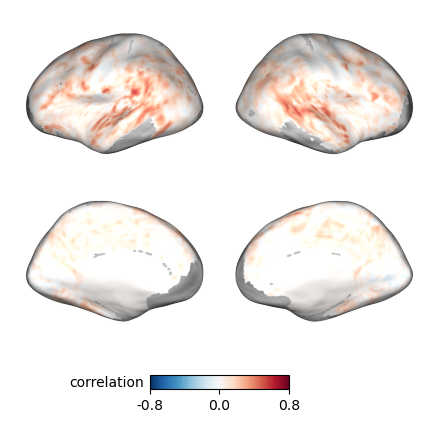

In [6]:
surfs, data = plotting.vol_to_surf(mni_data)

layer = plotting.make_layers_dict(data=data, cmap='RdBu_r', label=f'correlation', alpha=1, color_range=(-0.8, 0.8))

plotting.plot_surf_data(surfs, [layer], views=VIEWS, colorbar=COLORBAR, surf_type=SURF_TYPE, add_depth=ADD_DEPTH, 
					embed_nb=True)

In [44]:
data['left'].darrays[0]

<GiftiDataArray shape[40962]>

In [ ]:
mask

In [17]:
mni_data.shape

(56991,)

In [191]:
features.shape

(440, 6555)